# Project Gutenberg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ast
from scipy.stats import linregress
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Load the data
metadata = pd.read_csv('SPGC-metadata-2018-07-18.csv')
extra_controls = pd.read_csv('extra_controls.csv')
kld_scores = pd.read_csv('KLDscores.csv')
df=kld_scores
print(df.dtypes)

filename      object
kld_values    object
dtype: object


### Calculating Book Level Measure
<p> Calculated all the statistical summary based on kld scores, also calculated the slope of the linear regresiion fitted to these kld scores
<p> rather than taking any central tendecies as a book level score, we will calculate the score based on weights given to the mean, meadian, slope and standard deviation
<p> we have also calculated the kld trend based on slope of linear regression which tells us the narrative revelation with each section od the book 
<p> Additionally, we analyzed the KLD trend based on the slope of the linear regression, which provides insights into the narrative progression with each section of the book.

In [2]:
df['kld_values'] = df['kld_values'].apply(ast.literal_eval)

# Convert the list of KLD scores to a DataFrame
kld_df = df.explode('kld_values').reset_index(drop=True)
kld_df['kld_values'] = kld_df['kld_values'].astype(float)

# Compute summary statistics
stats_df = kld_df.groupby('filename')['kld_values'].agg(['mean', 'std', 'min', 'max', 'median'])

print(stats_df)

              mean       std       min       max    median
filename                                                  
PG100     0.244150  0.021638  0.198581  0.302100  0.244567
PG10002   0.234033  0.040963  0.192720  0.450747  0.223884
PG10003   0.241611  0.060391  0.200838  0.541167  0.229338
PG10005   0.243351  0.033588  0.206327  0.390158  0.239227
PG10008   0.240153  0.047886  0.204162  0.548940  0.233289
...            ...       ...       ...       ...       ...
PG9990    0.240779  0.028489  0.191770  0.313465  0.237820
PG9992    0.233802  0.028610  0.188639  0.356983  0.229047
PG9993    0.234510  0.025438  0.192124  0.338172  0.229159
PG9994    0.239589  0.040332  0.191390  0.448295  0.230224
PG9997    0.231092  0.032815  0.193730  0.372574  0.223464

[23193 rows x 5 columns]


In [3]:
def quantify_trend(kld_scores):
    x = np.arange(len(kld_scores))
    slope, intercept, r_value, p_value, std_err = linregress(x, kld_scores)
    trend_score = slope  # Slope of the linear regression line
    return trend_score

def process_kld_data(kld_data):
    trend_data = []

    for filename, kld_values in kld_data.items():
        trend_score = quantify_trend(kld_values)
        if trend_score > 0:
            trend = "Increasing Consistency"
        elif trend_score < 0:
            trend = "Decreasing Consistency"
        else:
            trend = "Irregular"

        trend_data.append({'filename': filename, 'slope': trend_score, 'kld_trend': trend})

    return pd.DataFrame(trend_data)

# Create a dictionary from the exploded DataFrame
kld_data = kld_df.groupby('filename')['kld_values'].apply(list).to_dict()

# Process the KLD data and get trends
trend_df = process_kld_data(kld_data)

# Merge the trend data with the stats_df
stats_df = stats_df.merge(trend_df, on='filename')

print(stats_df)
stats_df['kld_trend'].value_counts()

      filename      mean       std       min       max    median     slope  \
0        PG100  0.244150  0.021638  0.198581  0.302100  0.244567  0.000112   
1      PG10002  0.234033  0.040963  0.192720  0.450747  0.223884  0.000870   
2      PG10003  0.241611  0.060391  0.200838  0.541167  0.229338  0.001259   
3      PG10005  0.243351  0.033588  0.206327  0.390158  0.239227  0.000143   
4      PG10008  0.240153  0.047886  0.204162  0.548940  0.233289  0.000813   
...        ...       ...       ...       ...       ...       ...       ...   
23188   PG9990  0.240779  0.028489  0.191770  0.313465  0.237820  0.000557   
23189   PG9992  0.233802  0.028610  0.188639  0.356983  0.229047  0.000086   
23190   PG9993  0.234510  0.025438  0.192124  0.338172  0.229159  0.000134   
23191   PG9994  0.239589  0.040332  0.191390  0.448295  0.230224  0.000963   
23192   PG9997  0.231092  0.032815  0.193730  0.372574  0.223464  0.000056   

                    kld_trend  
0      Increasing Consistency  

Increasing Consistency    17404
Decreasing Consistency     5789
Name: kld_trend, dtype: int64

### Defining weights for Book Level Measure

In [4]:
# Define weights to prioritize increasing complexity and variability in the narrative
w_mean = 0.2
w_median = 0.2
w_slope = 0.3
w_std = 0.3

# Calculate the Revelation Score
stats_df['Revelation Score'] = (w_mean * stats_df['mean'] +
                          w_median * stats_df['median'] +
                          w_slope * stats_df['slope'] +
                          w_std * stats_df['std'])
#stats_df['Revelation Score (scaled)'] = (stats_df['Revelation Score'] - stats_df['Revelation Score'].min()) / (stats_df['Revelation Score'].max() - stats_df['Revelation Score'].min())
# Print the DataFrame with the Revelation Score
print(stats_df)

      filename      mean       std       min       max    median     slope  \
0        PG100  0.244150  0.021638  0.198581  0.302100  0.244567  0.000112   
1      PG10002  0.234033  0.040963  0.192720  0.450747  0.223884  0.000870   
2      PG10003  0.241611  0.060391  0.200838  0.541167  0.229338  0.001259   
3      PG10005  0.243351  0.033588  0.206327  0.390158  0.239227  0.000143   
4      PG10008  0.240153  0.047886  0.204162  0.548940  0.233289  0.000813   
...        ...       ...       ...       ...       ...       ...       ...   
23188   PG9990  0.240779  0.028489  0.191770  0.313465  0.237820  0.000557   
23189   PG9992  0.233802  0.028610  0.188639  0.356983  0.229047  0.000086   
23190   PG9993  0.234510  0.025438  0.192124  0.338172  0.229159  0.000134   
23191   PG9994  0.239589  0.040332  0.191390  0.448295  0.230224  0.000963   
23192   PG9997  0.231092  0.032815  0.193730  0.372574  0.223464  0.000056   

                    kld_trend  Revelation Score  
0      Increa

In [5]:
#print(stats_df['Revelation Score (scaled)'].describe())

## Relating different predictors and Revelation Score with log(downloads) using regression

In [6]:
stats_df.rename(columns={'filename': 'id'}, inplace=True)

result = pd.merge(extra_controls, metadata, on=['id', 'id'], how='outer')
result = pd.merge(result, stats_df, on=['id', 'id'], how='outer')
result.dropna(subset=['wordcount', 'downloads','Revelation Score'], inplace=True)
result['wordcount (scaled)'] = (result['wordcount'] - result['wordcount'].min()) / (result['wordcount'].max() - result['wordcount'].min())
result.isna().sum()


id                         0
subj2_war                  0
subj2_adventure            0
subj2_comedy               0
subj2_biography            0
subj2_romance              0
subj2_drama                0
subj2_fantasy              0
subj2_family               0
subj2_sciencefiction       0
subj2_action               0
subj2_thriller             0
subj2_western              0
subj2_horror               0
subj2_mystery              0
subj2_crime                0
subj2_history              0
subj2_periodicals          0
subj2_others               0
speed                      0
sentiment_avg              0
sentiment_vol              0
wordcount                  0
title                      0
author                   191
authoryearofbirth       1147
authoryearofdeath       1217
language                   0
downloads                  0
subjects                   0
type                       0
mean                       0
std                        0
min                        0
max           

In [7]:
# Log-transform the downloads
result['log_downloads'] = np.log(result['downloads'] + 1)  # Add 1 to avoid log(0)

# Define the predictors (X) and response (y)
X = result[['sentiment_avg','sentiment_vol', 'slope','Revelation Score','wordcount (scaled)']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = result['log_downloads']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     139.5
Date:                Wed, 03 Jul 2024   Prob (F-statistic):          1.11e-142
Time:                        17:29:13   Log-Likelihood:                -12779.
No. Observations:                8534   AIC:                         2.557e+04
Df Residuals:                    8528   BIC:                         2.561e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.4477      0

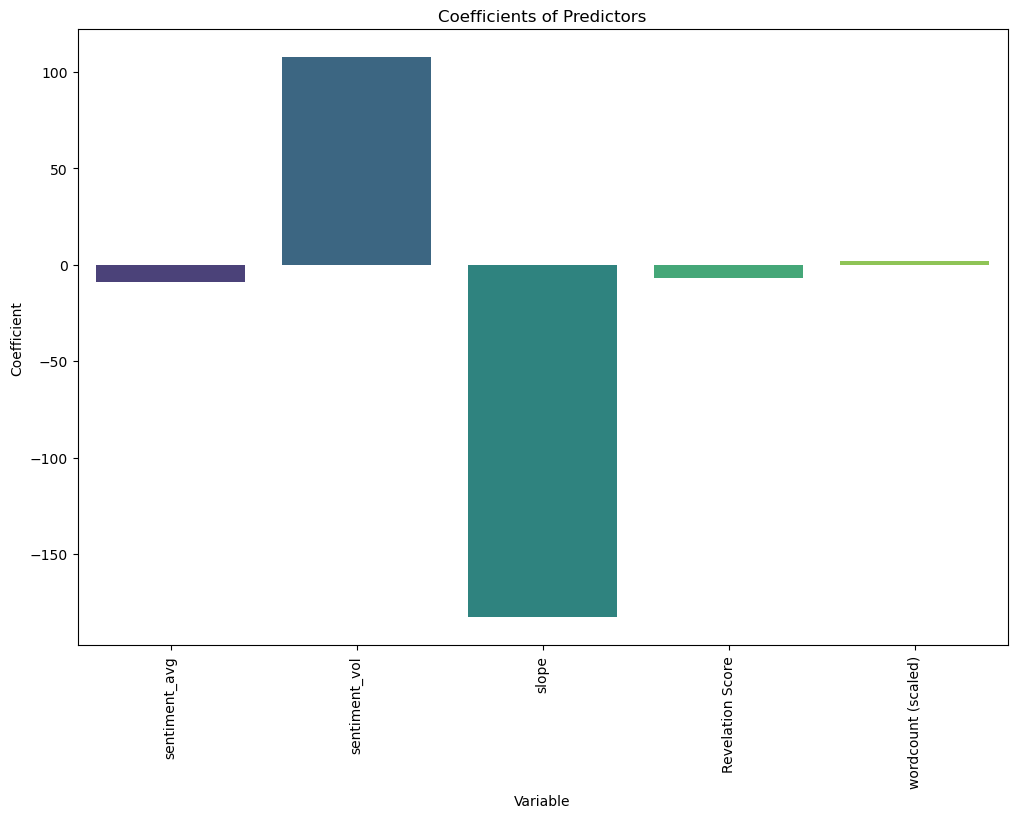

In [8]:
plot_data = pd.DataFrame({
    'Variable': X.columns[1:],  # Exclude the constant term
    'Coefficient': model.params[1:]  # Exclude the constant term
})
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data, x='Variable', y='Coefficient', palette='viridis')
plt.xticks(rotation=90)
plt.title('Coefficients of Predictors')
plt.show()


<p>The slope is negatively correlated with the logarithm of downloads. This indicates that books with a steeper increase in narrative revelation (as indicated by a higher slope) tend to have fewer downloads when compared to books with a more gradual increase in revelations. In other words, as the narrative becomes increasingly revealing towards the end, the popularity, as measured by downloads, tends to decrease. This negative correlation could imply that readers prefer books with a steadier flow of information rather than a dramatic buildup towards the conclusion.</p>
<p>The sentiment volatility is positively correlated with the logarithm of downloads. This means that books with higher fluctuations in sentiment tend to have more downloads. In other words, readers seem to favor books that exhibit greater emotional variation, suggesting that dynamic and emotionally diverse narratives are more appealing and popular among readers.</p>


## Investigating Hetrogeneity across various genre

OLS Regression Results for subj2_war:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     16.58
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           9.42e-18
Time:                        17:29:13   Log-Likelihood:                -910.68
No. Observations:                 615   AIC:                             1835.
Df Residuals:                     608   BIC:                             1866.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

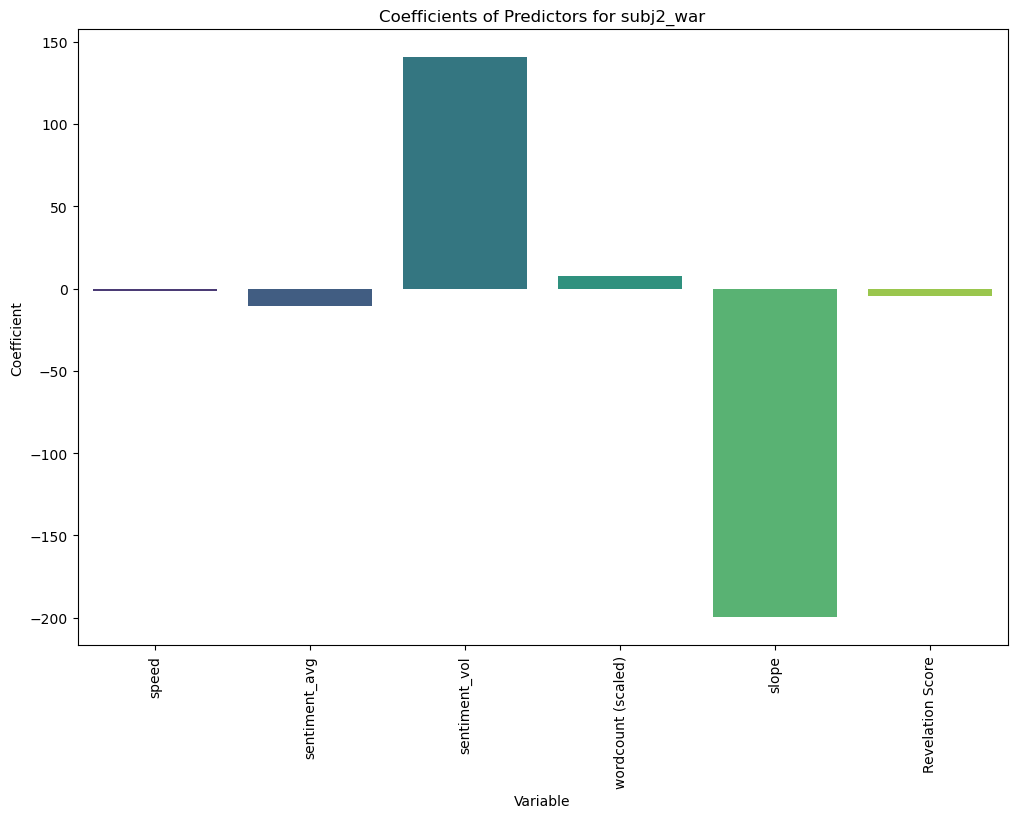

OLS Regression Results for subj2_adventure:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     24.86
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           2.58e-26
Time:                        17:29:14   Log-Likelihood:                -876.64
No. Observations:                 593   AIC:                             1767.
Df Residuals:                     586   BIC:                             1798.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

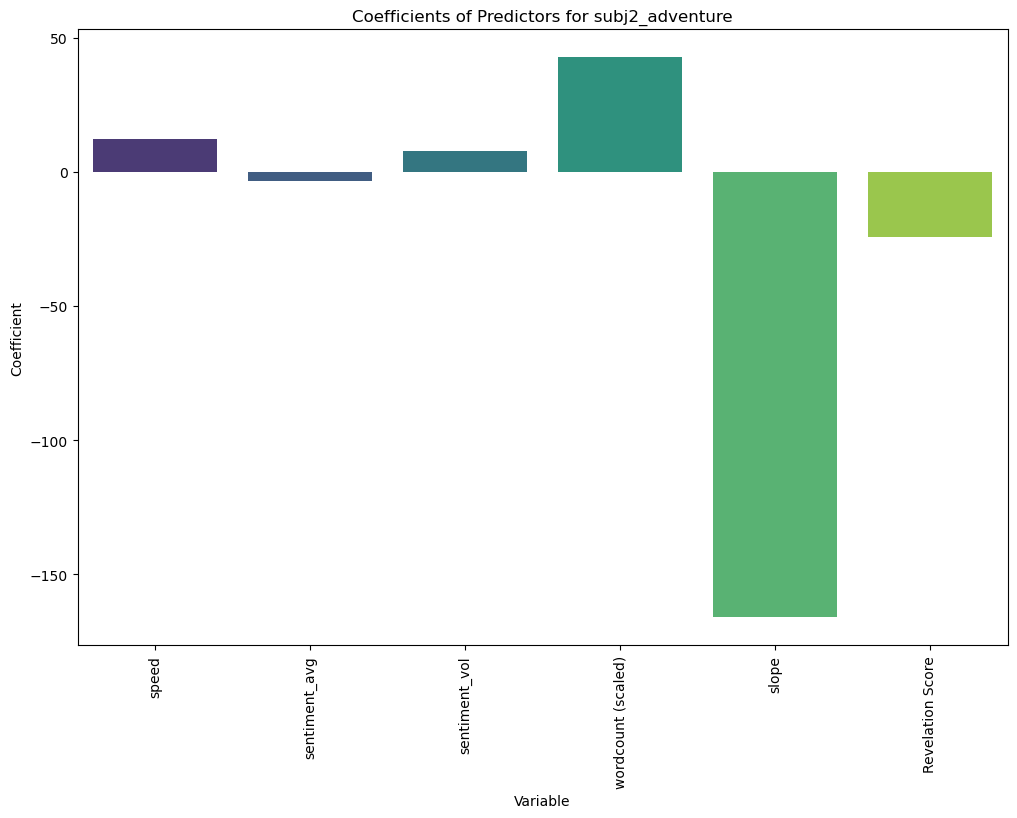

Skipping genre subj2_comedy due to insufficient data (less than 2 entries).
OLS Regression Results for subj2_biography:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                    0.5148
Date:                Wed, 03 Jul 2024   Prob (F-statistic):              0.793
Time:                        17:29:14   Log-Likelihood:                -61.827
No. Observations:                  45   AIC:                             137.7
Df Residuals:                      38   BIC:                             150.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--

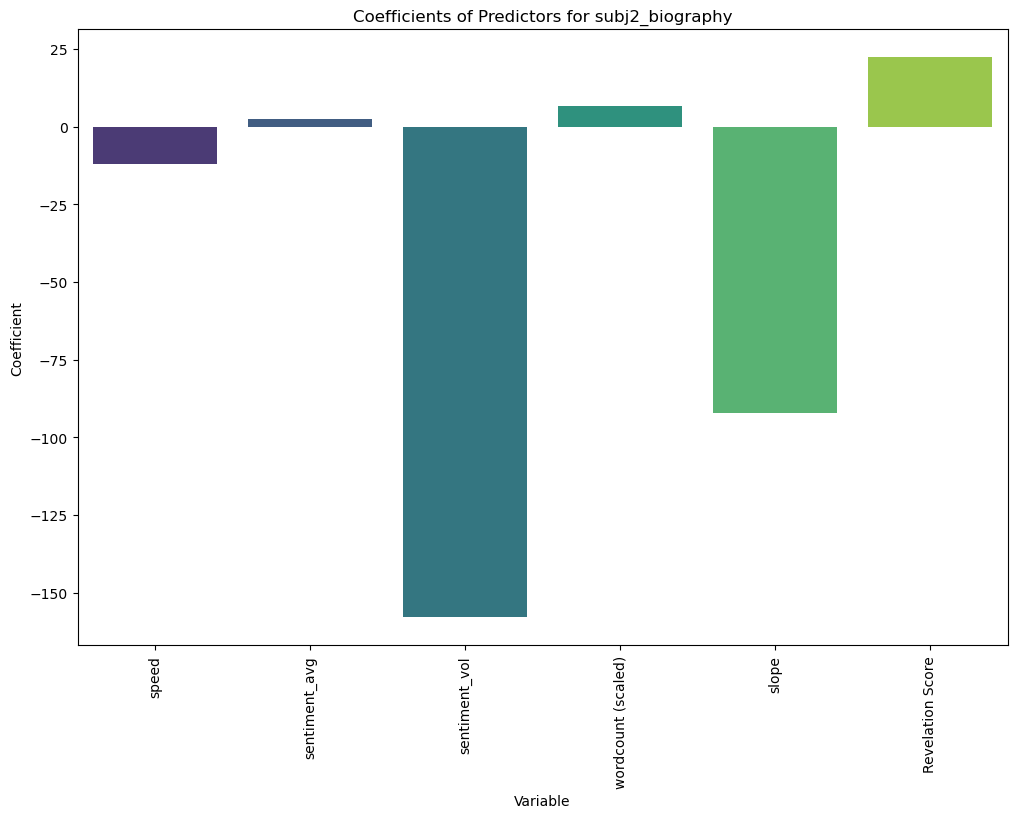

OLS Regression Results for subj2_romance:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     23.01
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.74e-23
Time:                        17:29:14   Log-Likelihood:                -680.71
No. Observations:                 425   AIC:                             1375.
Df Residuals:                     418   BIC:                             1404.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

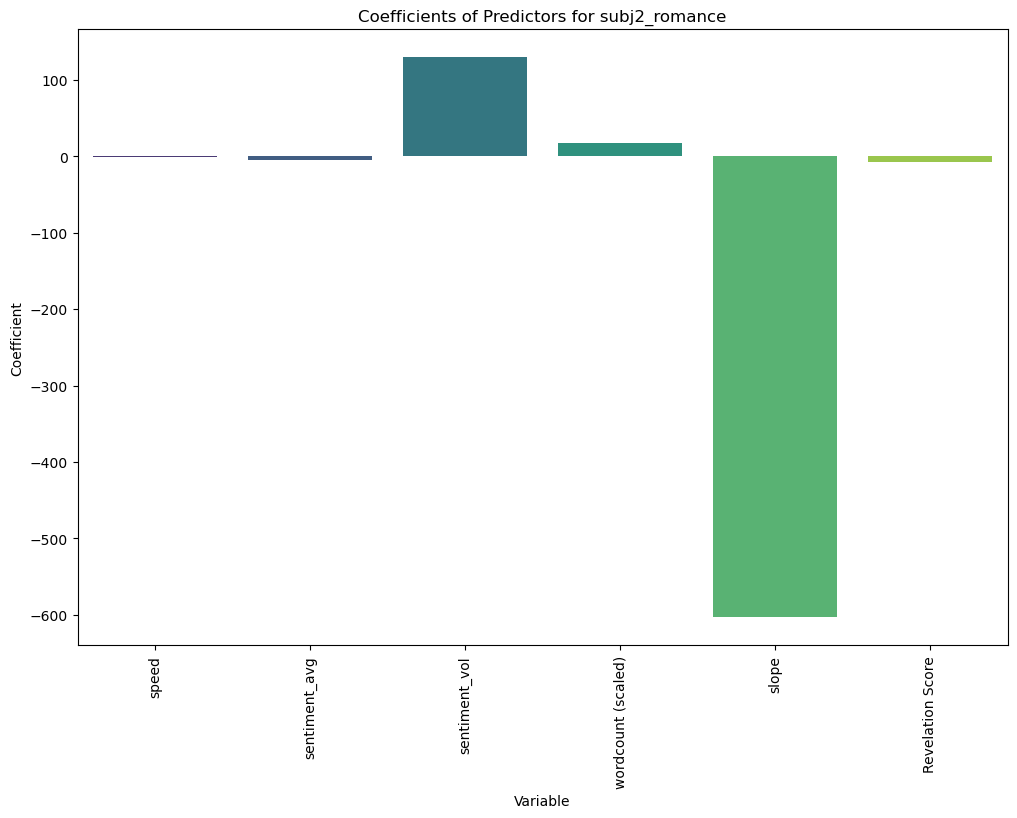

OLS Regression Results for subj2_drama:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                 -0.188
Method:                 Least Squares   F-statistic:                    0.6836
Date:                Wed, 03 Jul 2024   Prob (F-statistic):              0.672
Time:                        17:29:14   Log-Likelihood:                -15.188
No. Observations:                  13   AIC:                             44.38
Df Residuals:                       6   BIC:                             48.33
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

C:\Users\yesit\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


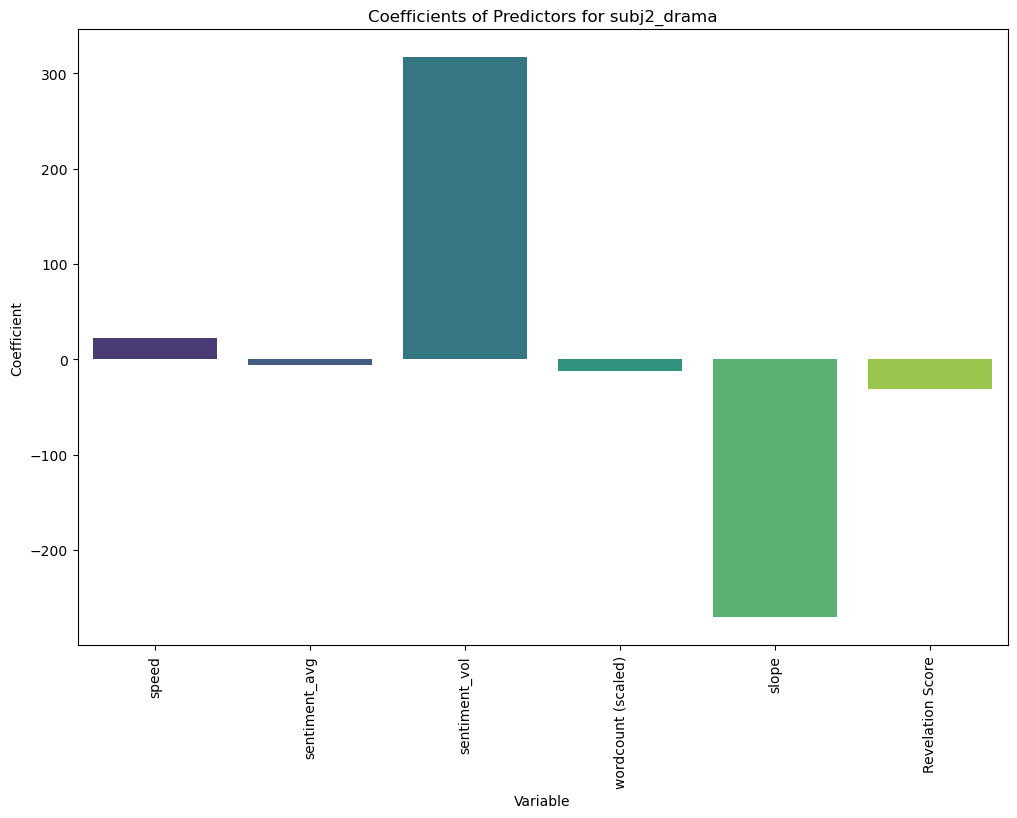

OLS Regression Results for subj2_fantasy:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.724
Date:                Wed, 03 Jul 2024   Prob (F-statistic):             0.0165
Time:                        17:29:14   Log-Likelihood:                -194.07
No. Observations:                 120   AIC:                             402.1
Df Residuals:                     113   BIC:                             421.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

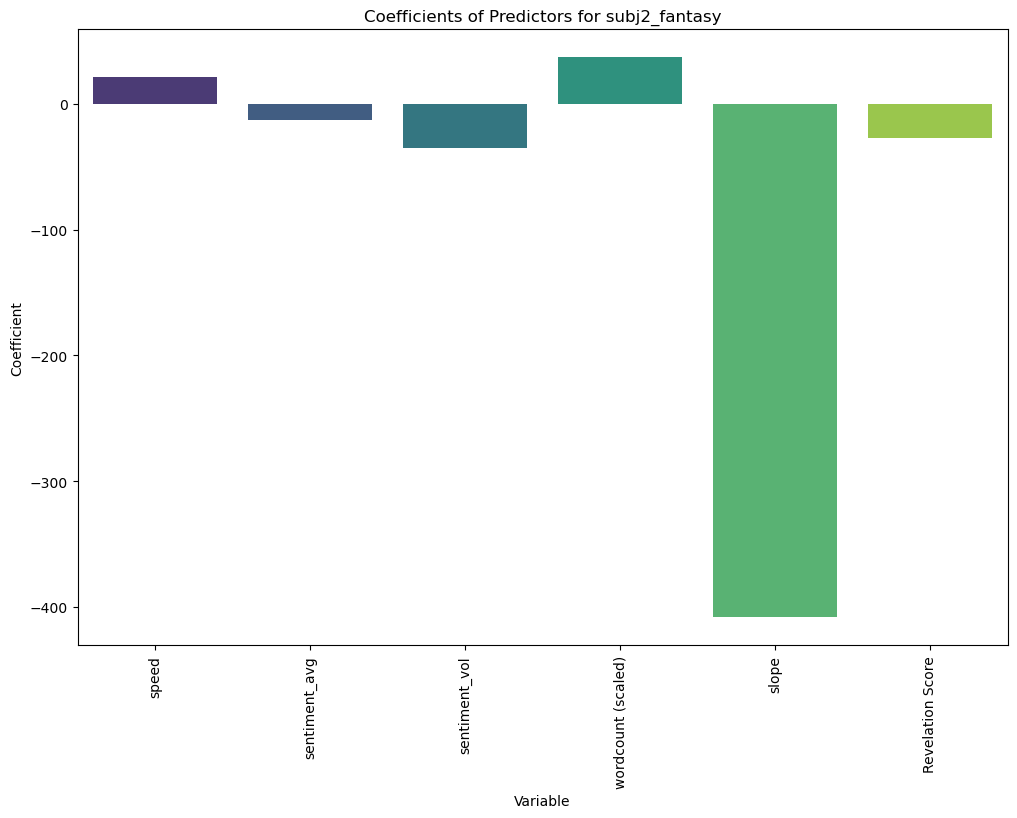

OLS Regression Results for subj2_family:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.581
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           3.82e-05
Time:                        17:29:14   Log-Likelihood:                -183.33
No. Observations:                 129   AIC:                             380.7
Df Residuals:                     122   BIC:                             400.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

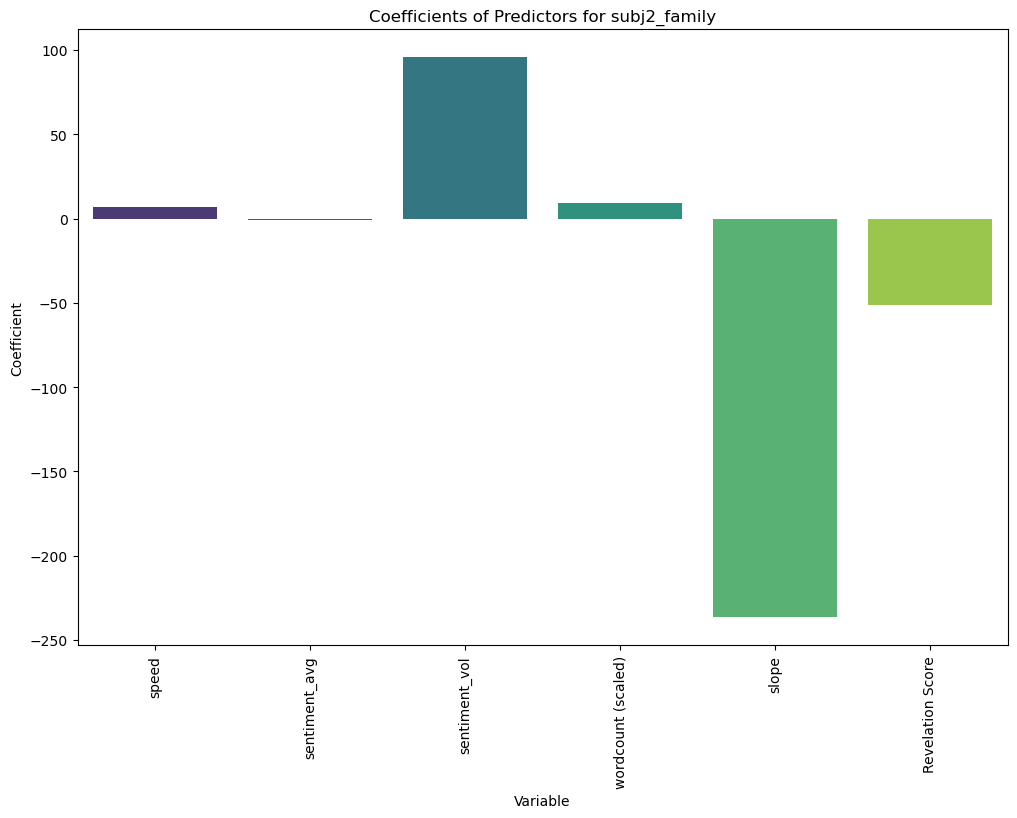

OLS Regression Results for subj2_sciencefiction:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     7.829
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.33e-07
Time:                        17:29:15   Log-Likelihood:                -303.11
No. Observations:                 213   AIC:                             620.2
Df Residuals:                     206   BIC:                             643.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

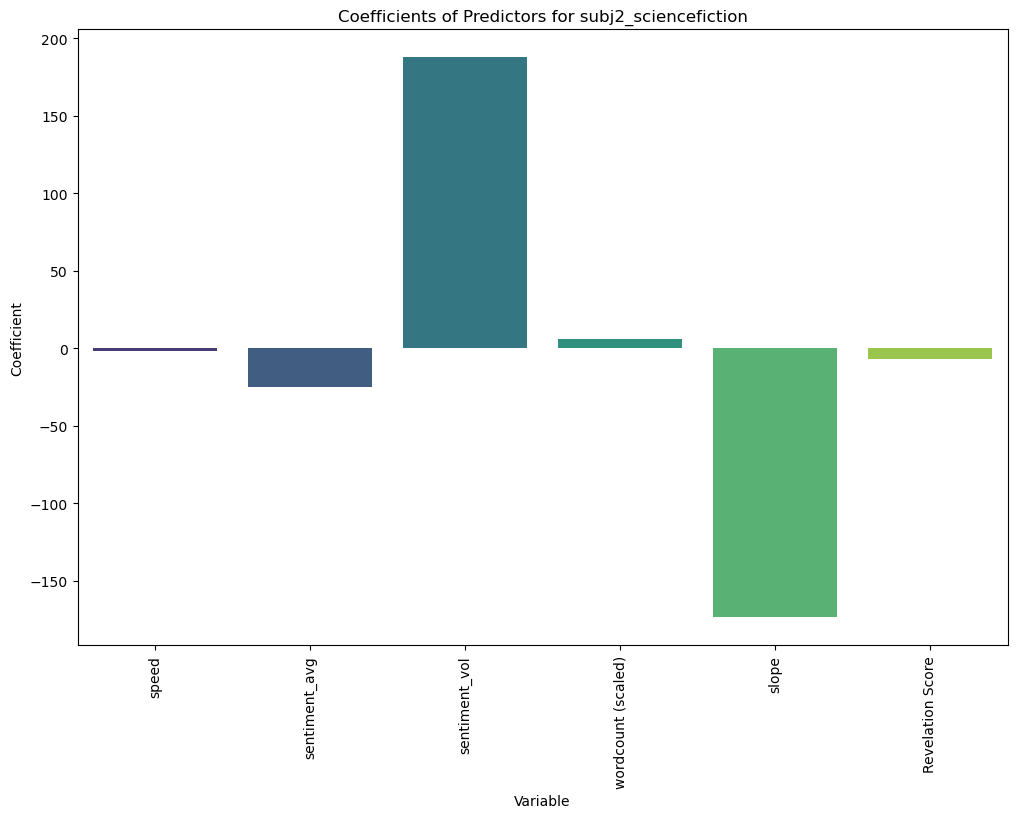

Skipping genre subj2_action due to insufficient data (less than 2 entries).
Skipping genre subj2_thriller due to insufficient data (less than 2 entries).
OLS Regression Results for subj2_western:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.958
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           0.000862
Time:                        17:29:15   Log-Likelihood:                -288.79
No. Observations:                 241   AIC:                             591.6
Df Residuals:                     234   BIC:                             616.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
             

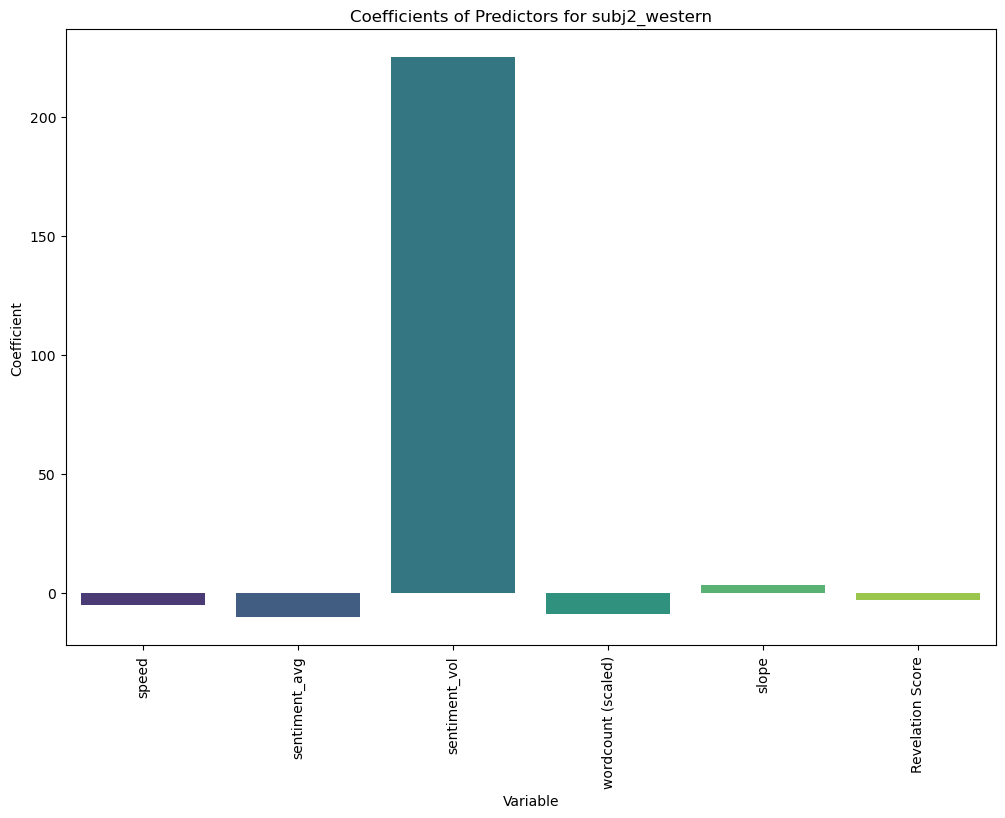

OLS Regression Results for subj2_horror:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.342
Date:                Wed, 03 Jul 2024   Prob (F-statistic):              0.265
Time:                        17:29:15   Log-Likelihood:                -70.547
No. Observations:                  42   AIC:                             155.1
Df Residuals:                      35   BIC:                             167.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

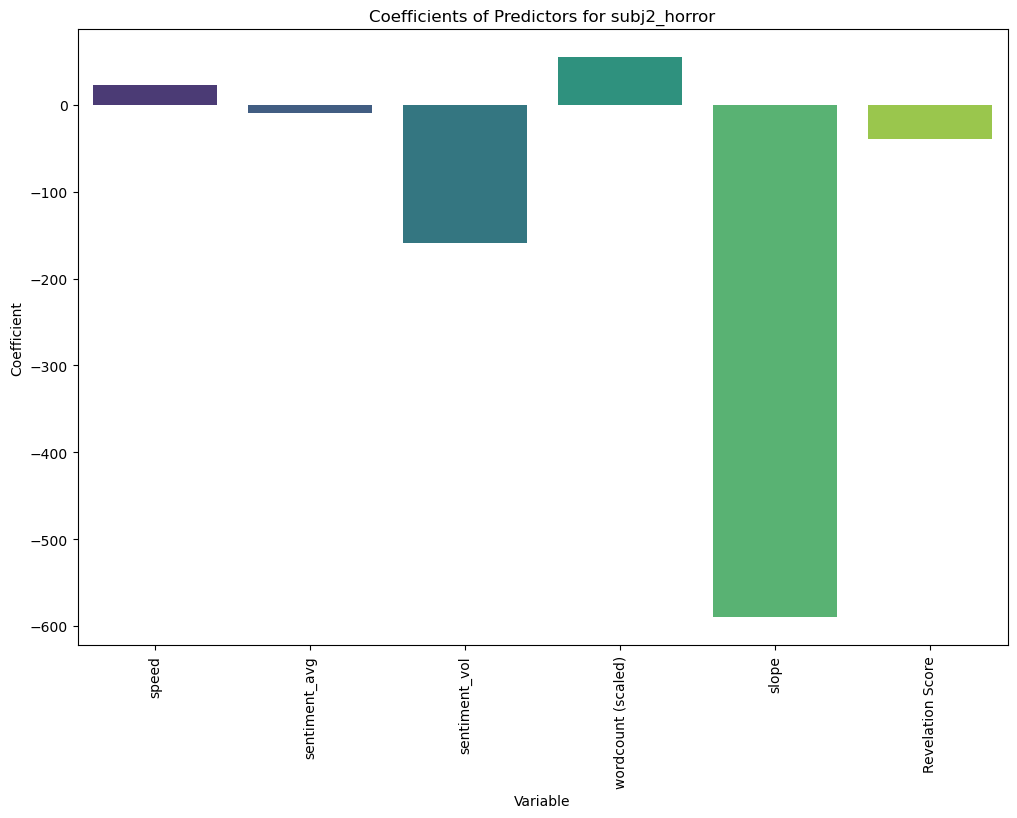

OLS Regression Results for subj2_mystery:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     5.747
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           9.21e-06
Time:                        17:29:15   Log-Likelihood:                -636.88
No. Observations:                 426   AIC:                             1288.
Df Residuals:                     419   BIC:                             1316.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

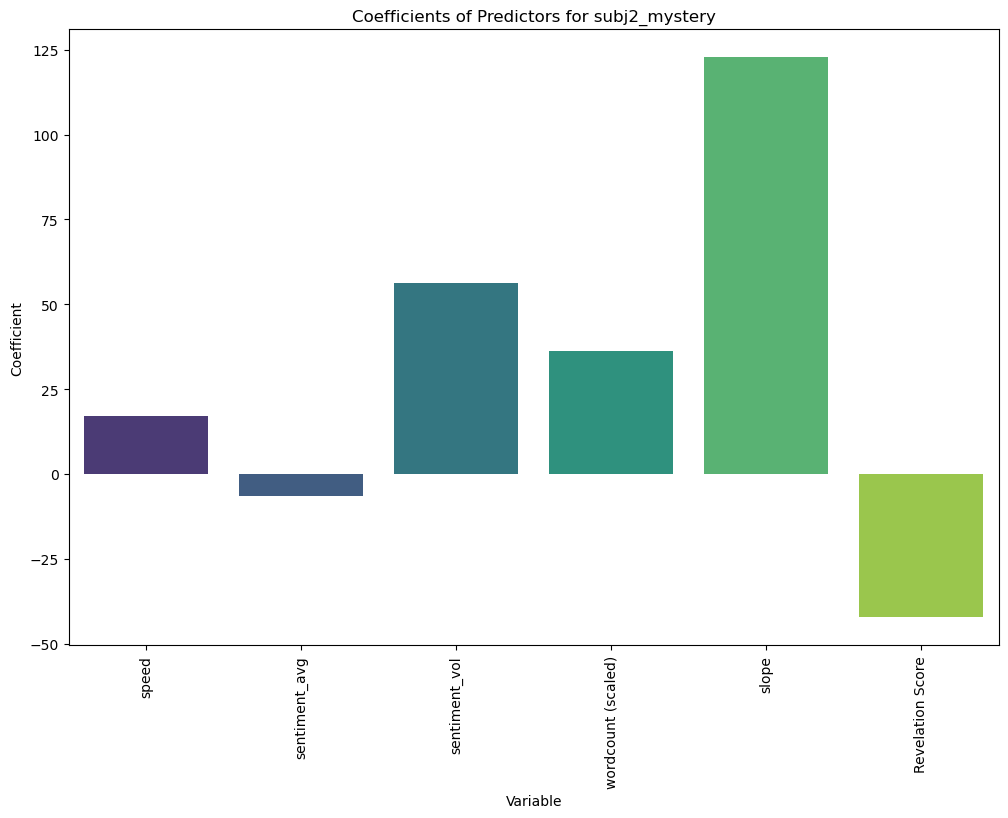

OLS Regression Results for subj2_crime:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     3.570
Date:                Wed, 03 Jul 2024   Prob (F-statistic):             0.0165
Time:                        17:29:16   Log-Likelihood:                -25.127
No. Observations:                  25   AIC:                             64.25
Df Residuals:                      18   BIC:                             72.79
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

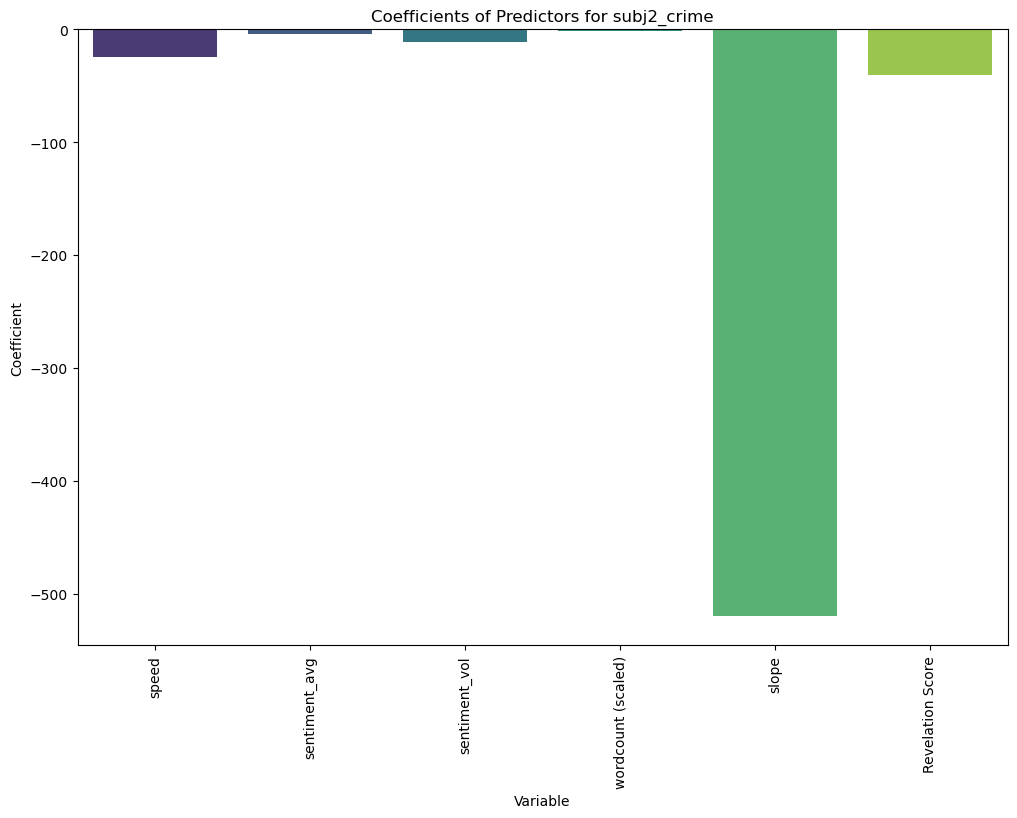

OLS Regression Results for subj2_history:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     9.198
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           7.24e-10
Time:                        17:29:16   Log-Likelihood:                -1804.7
No. Observations:                1197   AIC:                             3623.
Df Residuals:                    1190   BIC:                             3659.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

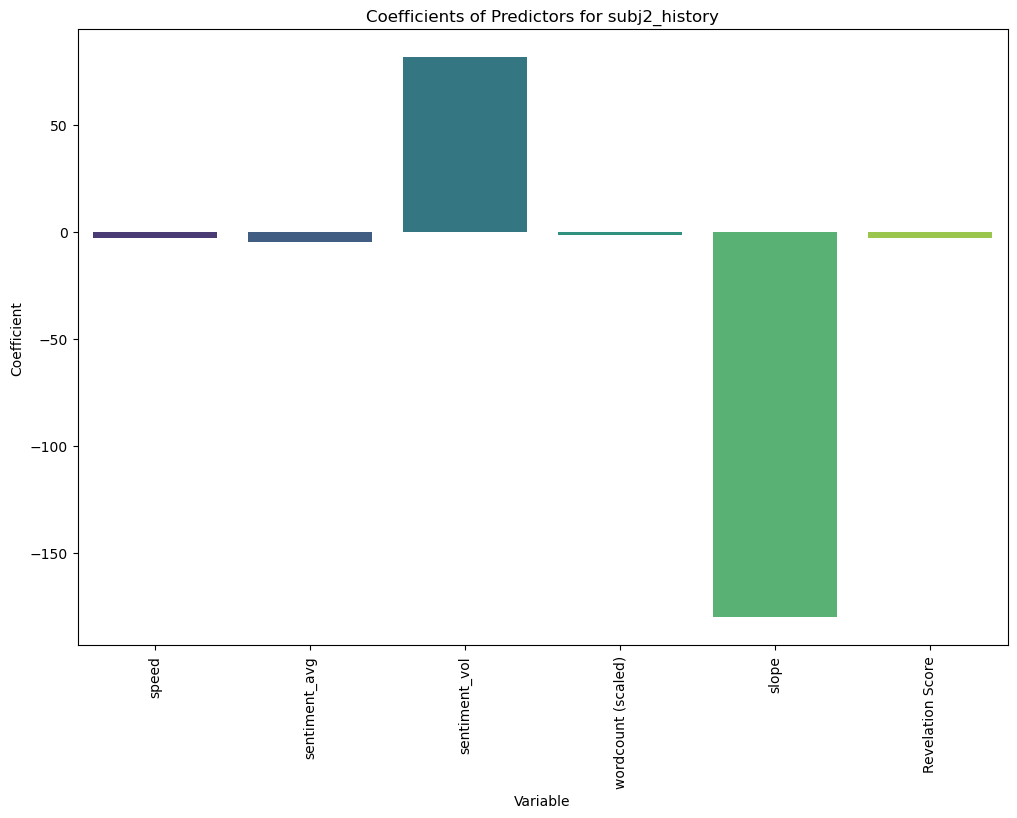

OLS Regression Results for subj2_periodicals:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     16.42
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.48e-15
Time:                        17:29:16   Log-Likelihood:                -280.41
No. Observations:                 222   AIC:                             574.8
Df Residuals:                     215   BIC:                             598.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

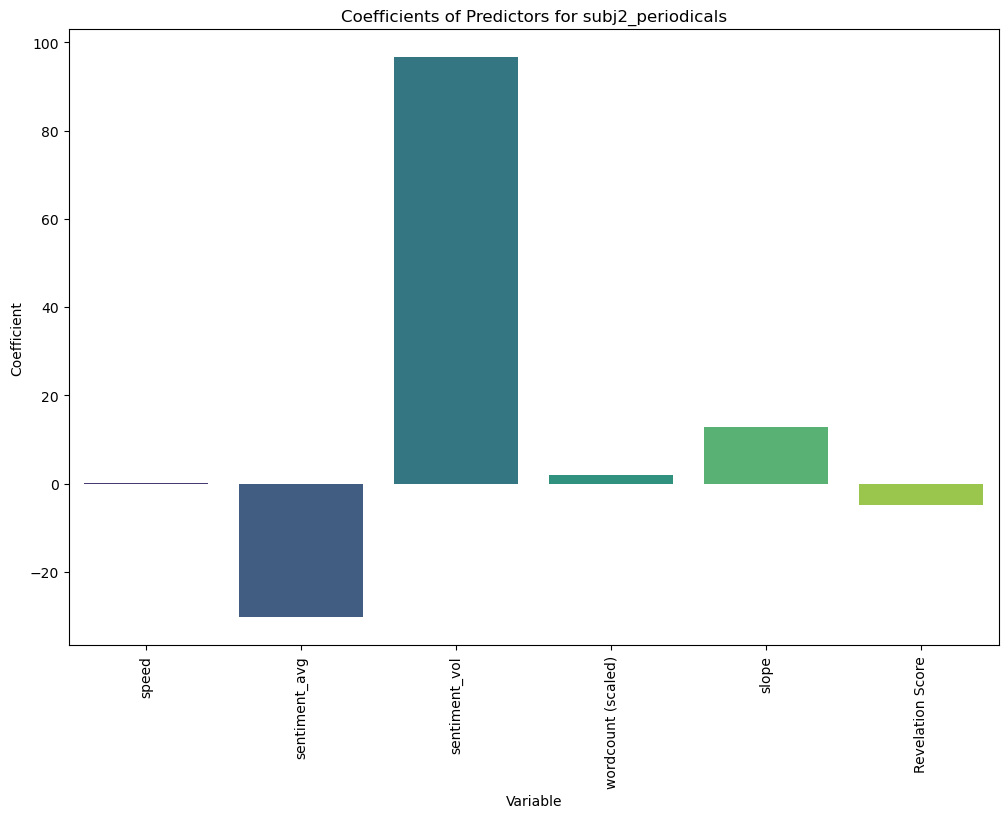

OLS Regression Results for subj2_others:

                            OLS Regression Results                            
Dep. Variable:          log_downloads   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     69.05
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           7.29e-83
Time:                        17:29:17   Log-Likelihood:                -7071.2
No. Observations:                4965   AIC:                         1.416e+04
Df Residuals:                    4958   BIC:                         1.420e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

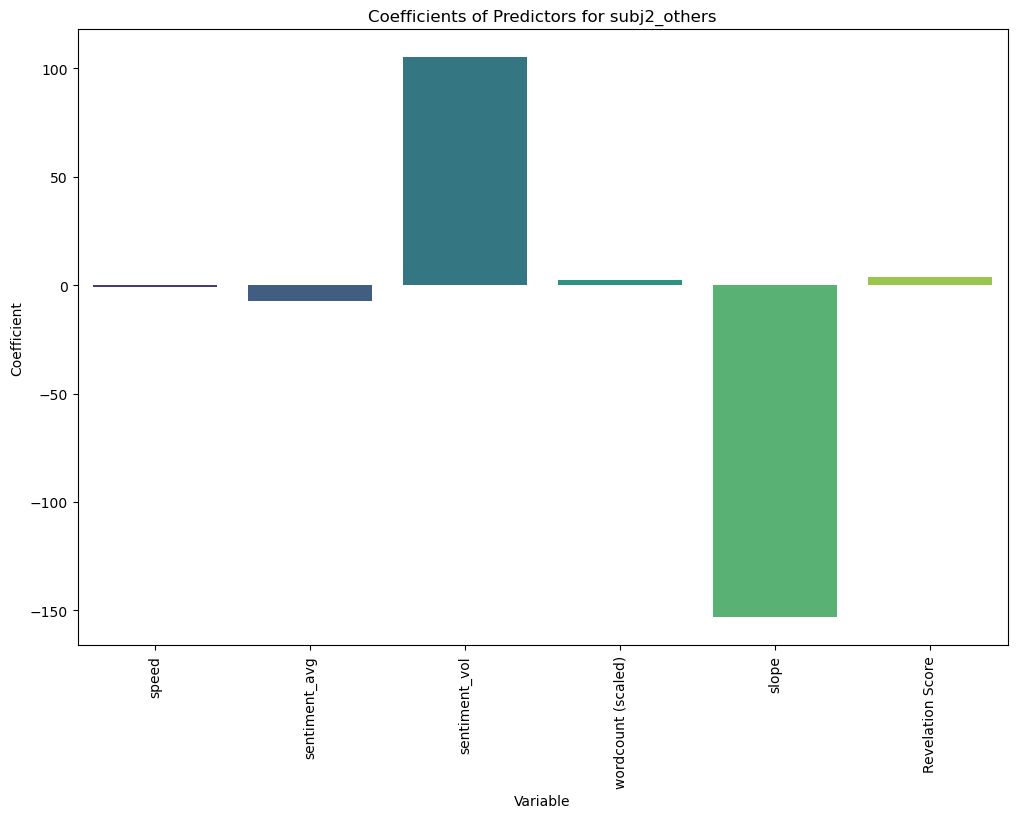

In [9]:
genres = ['subj2_war', 'subj2_adventure', 'subj2_comedy', 'subj2_biography', 
          'subj2_romance', 'subj2_drama', 'subj2_fantasy', 'subj2_family', 
          'subj2_sciencefiction', 'subj2_action', 'subj2_thriller', 
          'subj2_western', 'subj2_horror', 'subj2_mystery', 'subj2_crime', 
          'subj2_history', 'subj2_periodicals', 'subj2_others']

# Loop ach genre
for genre in genres:
    genre_data = result[result[genre] == 1]
    if len(genre_data) < 2:
        print(f"Skipping genre {genre} due to insufficient data (less than 2 entries).")
        continue
    
    if not genre_data.empty:
        # Prepare the data for the model
        X_genre = genre_data[['speed', 'sentiment_avg', 'sentiment_vol', 'wordcount (scaled)', 'slope', 'Revelation Score']]
        y_genre = genre_data['log_downloads']
        X_genre = sm.add_constant(X_genre)
        
        # Fit OLS model
        model_genre = sm.OLS(y_genre, X_genre).fit()
        print(f"OLS Regression Results for {genre}:\n")
        print(model_genre.summary())
        print("\n" + "="*80 + "\n")
        
        # Create plot data
        plot_data = pd.DataFrame({
            'Variable': X_genre.columns,  # Extract column names from X_genre
            'Coefficient': model_genre.params  # Get coefficients from the model
        }).reset_index(drop=True)
        
        # Exclude the constant term
        plot_data = plot_data[plot_data['Variable'] != 'const']
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        sns.barplot(data=plot_data, x='Variable', y='Coefficient', palette='viridis')
        plt.xticks(rotation=90)
        plt.title(f'Coefficients of Predictors for {genre}')
        plt.show()


<p>We observe significant differences in how predictors affect log_downloads across genres. The graphs from each genres regression models reveal that each parameter, such as sentiment_avg or speed, has a distinct impact on log downloads, as shown by the varying coefficients. By examining these coefficients in the plots, we can see how the role of each predictor changes from one genre to another, illustrating the heterogeneous effects of these variables across different categories.</p> <br>
Ex: For the Western genre, sentiment volatility is a primary predictor of log_downloads, while for the Science Fiction genre, both slope and sentiment volatility play significant roles. This suggests that in Westerns, the variability in sentiment is more important for predicting downloads, whereas in Science Fiction, both the trend over time (slope) and the variability in sentiment are crucial factors


## Lasso Regularization for identifying predictors

Non-zero LASSO coefficients:
             Variable  Coefficient
0               speed    -0.038820
1       sentiment_avg    -0.203697
2       sentiment_vol     0.192287
3  wordcount (scaled)     0.050170
4               slope    -0.086525
5    Revelation Score    -0.027216


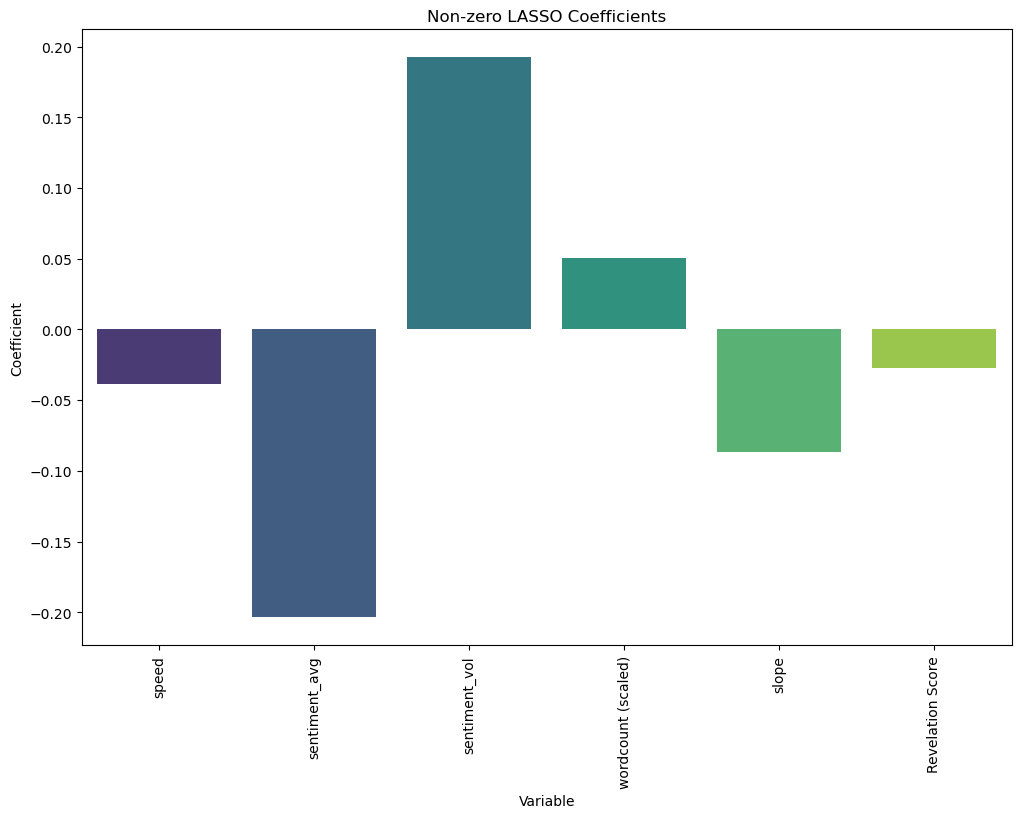

In [10]:
# Prepare the data
X = result[['speed', 'sentiment_avg','sentiment_vol', 'wordcount (scaled)', 'slope','Revelation Score']]
y = result['log_downloads']

# Standardize the data and fit LASSO
lasso = make_pipeline(StandardScaler(), LassoCV(cv=10))
lasso.fit(X, y)

# Get the coefficients
lasso_coefficients = lasso.named_steps['lassocv'].coef_
lasso_intercept = lasso.named_steps['lassocv'].intercept_

# Create a DataFrame for the coefficients
lasso_coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': lasso_coefficients
})

# Print the non-zero coefficients
print("Non-zero LASSO coefficients:")
print(lasso_coef_df[lasso_coef_df['Coefficient'] != 0])
# Visualize
plt.figure(figsize=(12, 8))
sns.barplot(data=lasso_coef_df[lasso_coef_df['Coefficient'] != 0], x='Variable', y='Coefficient', palette='viridis')
plt.xticks(rotation=90)
plt.title('Non-zero LASSO Coefficients')
plt.show()


<b>speed:</b> A slight negative impact on the target variable.<br>
<b>sentiment_avg:</b> A relatively strong negative impact on the target variable.<br>
<b>sentiment_vol:</b> A moderate positive impact on the target variable.<br>
<b>wordcount (scaled):</b> A small positive impact on the target variable.<br>
<b>slope:</b> A moderate negative impact on the target variable.<br>
<b>Revelation Score:</b> A slight negative impact on the target variable.<br>


<b>Based on the magnitude of the coefficients:</b><br>
Sentiment_avg and Sentiment_vol are the most influential features.<br>
Slope also has a relatively significant impact compared to the others.
